In [ ]:
%matplotlib inline
# OPTIONAL: Load the "autoreload" extension so that the code can change
%load_ext autoreload
%autoreload 2

In [56]:
import os
import sys
from pathlib import Path
import urllib
import zipfile
from typing import Dict, List
from feature_engine import encoding, imputation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    base,
    compose,
    datasets,
    ensemble,
    metrics,
    model_selection,
    pipeline,
    preprocessing,
)
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection
from yellowbrick import classifier
import dtreeviz
from hyperopt import fmin, tpe, hp, Trials

In [ ]:
from src.data.Utils import Utils
from src.data.KagTransformer import TweakKagTransformer

In [ ]:
plt.style.use("ggplot")

# Set Variables

In [ ]:
url: str = (
    "https://github.com/mattharrison/datasets/raw/master/data/" "kaggle-survey-2018.zip"
)
folder_name: str = "kaggle-survey-2018.zip"
member_name: str = "multipleChoiceResponses.csv"

In [ ]:
# Paths
HOME: Path = Path.cwd().parents
data_folder: str = HOME[1] / f"data/raw/{folder_name}"
figures_folder: str = HOME[1] / "reports/figures"

### Datasets

In [ ]:
raw = Utils.extract_zip(src=url, dst=data_folder, member_name=member_name)

## Create raw X and raw y

In [ ]:
kag_X, kag_y = Utils.get_rawx_y(df=raw, y_col="Q6")

## Splitdata

In [ ]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X, kag_y, test_size=0.3, random_state=42, stratify=kag_y
)

## Trasform X with pipeline

In [ ]:
kag_pl = pipeline.Pipeline(
    [
        ("tweak", TweakKagTransformer()),
        (
            "cat",
            encoding.OneHotEncoder(
                top_categories=5, drop_last=True, variables=["Q1", "Q3", "major"]
            ),
        ),
        (
            "num_impute",
            imputation.MeanMedianImputer(
                imputation_method="median", variables=["education", "years_exp"]
            ),
        ),
    ]
)

In [ ]:
X_train = kag_pl.fit_transform(kag_X_train)
X_test = kag_pl.transform(kag_X_test)

## Transform y with label encoder

In [ ]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)

# Combined data for cross validation/etc

In [ ]:
X = pd.concat([X_train, X_test])
y = pd.Series([*y_train, *y_test], index=X.index)

## A boosted model

In [ ]:
xg_oob = xgb.XGBClassifier()

In [ ]:
xg_oob.fit(X_train, y_train)

In [ ]:
xg_oob.score(X_test, y_test)

*Let's try w/ depth of 2 and 2 trees*

In [ ]:
xg2 = xgb.XGBClassifier(max_depth=2, n_estimators=2)

In [ ]:
xg2.fit(X_train, y_train)

In [ ]:
xg2.score(X_test, y_test)

In [ ]:
viz = dtreeviz.model(
    xg2,
    X_train=X,
    y_train=y,
    target_name="Job",
    feature_names=list(X_train.columns),
    class_names=["DS", "SE"],
    tree_index=0,
)
viz.view(depth_range_to_display=[0, 2])

In [ ]:
xgb.plot_tree(xg2, num_trees=0)

## Early Stopping
Reduce overfitting.

In [ ]:
# Defaults
xg = xgb.XGBClassifier()

In [ ]:
xg.fit(X_train, y_train)

In [ ]:
xg.score(X_test, y_test)

In [ ]:
# Customized early stopping
xg = xgb.XGBClassifier(early_stopping_rounds=20)

In [ ]:
xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

In [ ]:
xg.best_ntree_limit

### Plotting Tree performance
Validation_0 is for training data
Validation_1 is for testing data

In [ ]:
results = xg.evals_result()

In [ ]:
results

In [ ]:
# Testing score is best at 13 trees
fig, ax = plt.subplots(figsize=(8, 4))
ax = (
    pd.DataFrame(
        {
            "training": results["validation_0"]["logloss"],
            "testing": results["validation_1"]["logloss"],
        }
    )
    .assign(ntrees=lambda adf: range(1, len(adf) + 1))
    .set_index("ntrees")
    .plot(figsize=(5, 4), ax=ax, title="eval_results with early stopping")
)
ax.annotate(
    "best number \nof trees (13)",
    xy=(13, 0.498),
    xytext=(20, 0.42),
    arrowprops={"color": "k"},
)
ax.set_xlabel("ntrees")
plt.show()

In [ ]:
# using a value from early stopping gives same result
xg13 = xgb.XGBClassifier(n_estimators=13)

In [ ]:
xg13.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

In [ ]:
xg13.score(X_test, y_test)

In [ ]:
# No early stopping, uses all stimators
xg_no_est = xgb.XGBClassifier()

In [ ]:
xg_no_est.fit(X_train, y_train)

In [ ]:
xg_no_est.score(X_test, y_test)

In [ ]:
xg_error = xgb.XGBClassifier(early_stopping_rounds=20, eval_metric="error")

In [ ]:
xg_error.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

In [ ]:
xg_error.score(X_test, y_test)

In [ ]:
xg_error.best_ntree_limit

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
yellowbrick.model_selection.validation_curve(
    xgb.XGBClassifier(),
    X_train,
    y_train,
    param_name="gamma",
    param_range=[0, 0.5, 1, 5, 10, 20, 30],
    n_jobs=1,
    ax=ax,
)
plt.show()

### Learning Rate

In [ ]:
kg_lr1 = xgb.XGBClassifier(learning_rate=1, max_depth=2)

In [ ]:
kg_lr1.fit(X_train, y_train)

In [ ]:
xgb.plot_tree(kg_lr1, num_trees=0)

In [ ]:
# check impact of learning weight on scores
xg_lr_001 = xgb.XGBClassifier(learning_rate=0.01, max_depth=2)

In [ ]:
xg_lr_001.fit(X_train, y_train)

In [ ]:
xgb.plot_tree(xg_lr_001, num_trees=0)

## Grid Search

In [ ]:
params: Dict = {
    "reg_lambda": [0],  # No effect
    "learning_rate": [0.1, 0.3],  # makes each boost more conservative
    "subsample": [0.7, 1],
    "max_depth": [2, 3],
    "random_state": [42],
    "n_jobs": [-1],
    "n_estimators": [200],
}

In [ ]:
xgb2 = xgb.XGBClassifier(early_stopping_rounds=5)

In [ ]:
cv = model_selection.GridSearchCV(xgb2, params, cv=3, n_jobs=-1).fit(
    X_train, y_train, eval_set=[(X_test, y_test)], verbose=50
)

In [ ]:
cv.best_params_

In [ ]:
xgb_grid = xgb.XGBClassifier(**cv.best_params_, early_stopping_rounds=50)

In [ ]:
xgb_grid.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10
)

*vs default*

In [ ]:
xgb_def = xgb.XGBClassifier(early_stopping_rounds=50)

In [ ]:
xgb_def.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10
)

In [ ]:
xgb_def.score(X_test, y_test), xgb_grid.score(X_test, y_test)

*cross validation*

In [ ]:
results_default = model_selection.cross_val_score(xgb.XGBClassifier(), X=X, y=y, cv=4)

In [ ]:
results_default

In [ ]:
results_default.mean()

In [ ]:
results_grid = model_selection.cross_val_score(
    xgb.XGBClassifier(**cv.best_params_), X=X, y=y, cv=4
)

In [ ]:
results_grid

In [ ]:
results_grid.mean()

# Hyperot

```
long_params = {'colsample_bytree': 0.6874845219014455,
               'gamma': 0.06936323554883501,
               'learning_rate': 0.21439214284976907,
               'max_depth': 6,
               'min_child_weight': 0.6678357091609912,
               'reg_alpha': 3.2979862933185546,
               'reg_lambda': 7.850943400390477,
               'subsample': 0.999767483950891}
```

Excerpt From
Effective XGBoost
Matt Harrison
https://itunes.apple.com/WebObjects/MZStore.woa/wa/viewBook?id=0
This material may be protected by copyright.

In [ ]:
longs_params: Dict = {
    "colsample_bytree": 0.6874845219014455,
    "gamma": 0.06936323554883501,
    "learning_rate": 0.21439214284976907,
    "max_depth": 6,
    "min_child_weight": 0.6678357091609912,
    "reg_alpha": 3.2979862933185546,
    "reg_lambda": 7.850943400390477,
    "subsample": 0.999767483950891,
}

In [ ]:
xg_ex = xgb.XGBClassifier(**longs_params, early_stopping_rounds=50, n_estimators=500)

In [ ]:
xg_ex.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100
)

In [ ]:
xg_ex.score(X_test, y_test)

# Tuning with Hyperopt

In [ ]:
params: Dict = {"random_state": 42}

In [ ]:
rounds: List = [
    {
        "max_depth": hp.quniform("max_depth", 1, 8, 1),  # tree
        "min_child_weight": hp.loguniform("min_child_weight", -2, 3),
    },
    {
        "subsample": hp.uniform("subsample", 0.5, 1),  # stochastic
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    },
    {
        "reg_alpha": hp.uniform("reg_alpha", 0, 10),
        "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    },
    {"gamma": hp.loguniform("gamma", -10, 10)},  # regularization
    {"learning_rate": hp.loguniform("learning_rate", -7, 0)},  # boosting
]

In [ ]:
all_trials: List = []

In [ ]:
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(
        fn=lambda space: Utils.hyperparameter_tuning(
            space, X_train, y_train, X_test, y_test
        ),
        space=params,
        algo=tpe.suggest,
        max_evals=20,
        trials=trials,
    )
    params = {**params, **best}
    all_trials.append(trials)

In [ ]:
Utils.plot_3d_mesh(Utils.trial_to_df(all_trials[2]),
                   'reg_alpha', 'reg_lambda', 'loss')

# Taining and optimized model
```
step_params = {'random_state': 42,
 'max_depth': 5,
 'min_child_weight': 0.6411044640540848,
 'subsample': 0.9492383155577023,
 'colsample_bytree': 0.6235721099295888,
 'gamma': 0.00011273797329538491,
 'learning_rate': 0.24399020050740935}
```

Excerpt From
Effective XGBoost
Matt Harrison
https://itunes.apple.com/WebObjects/MZStore.woa/wa/viewBook?id=0
This material may be protected by copyright.

In [ ]:
step_params: Dict = {
    "random_state": 42,
    "max_depth": 5,
    "min_child_weight": 0.6411044640540848,
    "subsample": 0.9492383155577023,
    "colsample_bytree": 0.6235721099295888,
    "gamma": 0.00011273797329538491,
    "learning_rate": 0.24399020050740935,
}

In [36]:
xg_step = xgb.XGBClassifier(**step_params, early_stopping_rounds=50, n_estimators=500)

In [37]:
xg_step.fit(
    X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100
)

[0]	validation_0-logloss:0.64342	validation_1-logloss:0.64282
[86]	validation_0-logloss:0.36043	validation_1-logloss:0.51373


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6235721099295888, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.00011273797329538491, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.24399020050740935, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.6411044640540848, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [38]:
xg_step.score(X_test, y_test)

0.7613259668508288

# Learning curves
```
params = {'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}
```

Excerpt From
Effective XGBoost
Matt Harrison
https://itunes.apple.com/WebObjects/MZStore.woa/wa/viewBook?id=0
This material may be protected by copyright.

In [39]:
curve_params = {'learning_rate': 0.3,
 'max_depth': 2,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42,
 'reg_lambda': 0,
 'subsample': 1}

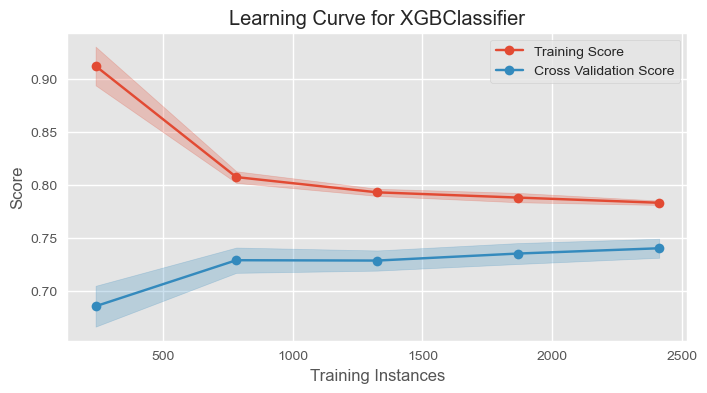

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))
viz = yellowbrick.model_selection.learning_curve(
    xgb.XGBClassifier(**curve_params), X, y, ax=ax
)
ax.set_ylim(.6, 1)
plt.show()

*Tunned Tree*

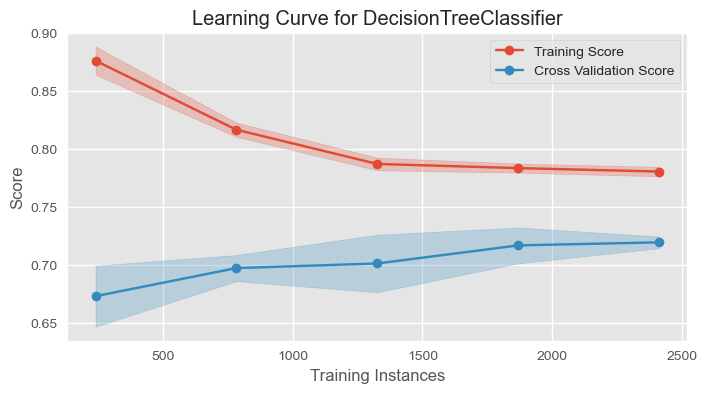

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))
viz = yellowbrick.model_selection.learning_curve(
    tree.DecisionTreeClassifier(max_depth=7),
    X, y, ax=ax
)
viz.ax.set_ylim(.6, 1)
plt.show()

### Underfit learning curve

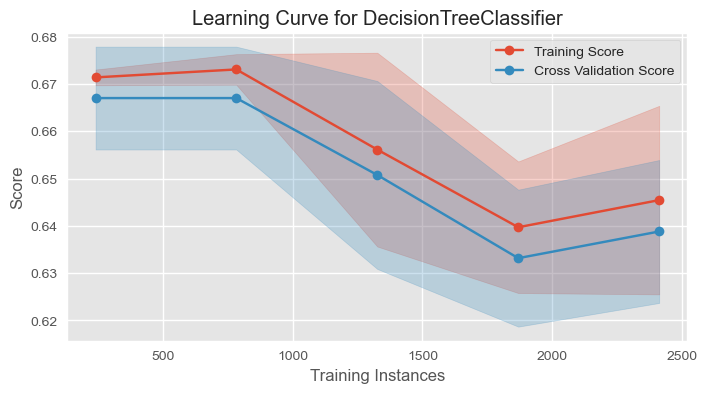

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
viz = yellowbrick.model_selection.learning_curve(
    tree.DecisionTreeClassifier(max_depth=1),
    X, y, ax=ax
)
viz.ax.set_ylim(0.6, 1)
plt.show()

### Overfit learning curve

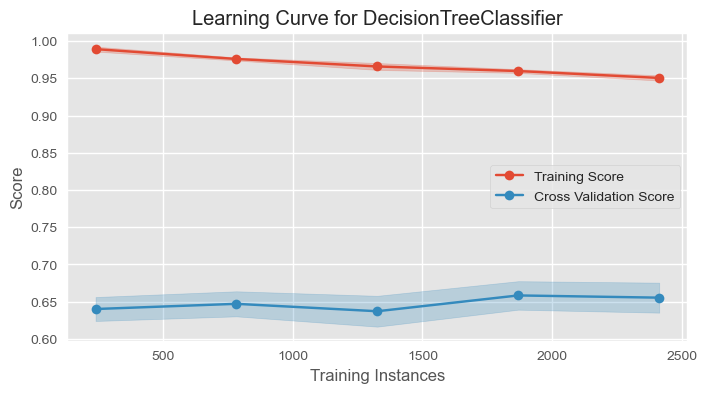

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
viz = yellowbrick.model_selection.learning_curve(
    tree.DecisionTreeClassifier(),
    X, y, ax=ax
)
viz.ax.set_ylim(0.6, 1)
plt.show()

# Model Evaluation

In [53]:
xgb_def = xgb.XGBClassifier()

In [54]:
xgb_def.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [55]:
xgb_def.score(X_test, y_test)

0.7458563535911602

In [57]:
metrics.accuracy_score(y_test, xgb_def.predict(X_test))

0.7458563535911602

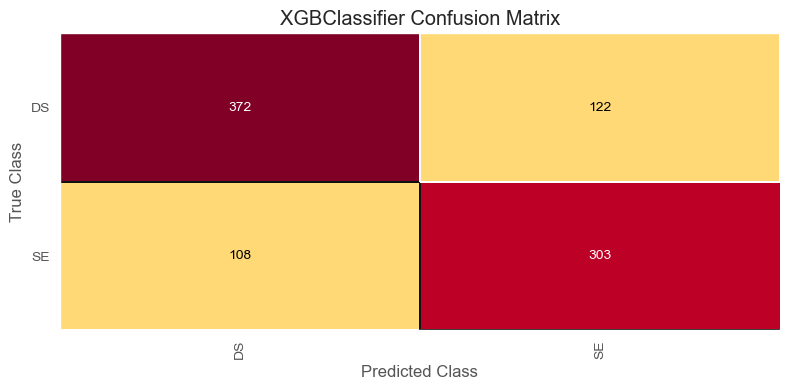

In [58]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.confusion_matrix(
    xgb_def, X_test, y_test, ax=ax, classes=['DS', 'SE']
)
plt.show()

In [60]:
cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test))

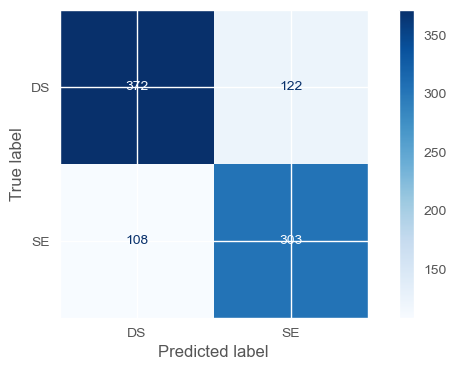

In [62]:
fig, ax = plt.subplots(figsize=(8, 4))
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=['DS', 'SE']
)
disp.plot(ax=ax, cmap='Blues')
plt.show()

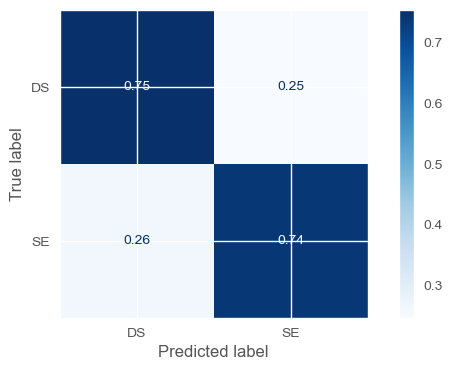

In [63]:
# Uses fraction of correct predictions
fig, ax = plt.subplots(figsize=(8, 4))
cm = metrics.confusion_matrix(y_test, xgb_def.predict(X_test), normalize='true')
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=['DS', 'SE']
)
disp.plot(ax=ax, cmap='Blues')
plt.show()

## Precision and Recall

In [64]:
metrics.precision_score(y_test, xgb_def.predict(X_test))

0.7129411764705882

In [65]:
metrics.recall_score(y_test, xgb_def.predict(X_test))

0.7372262773722628

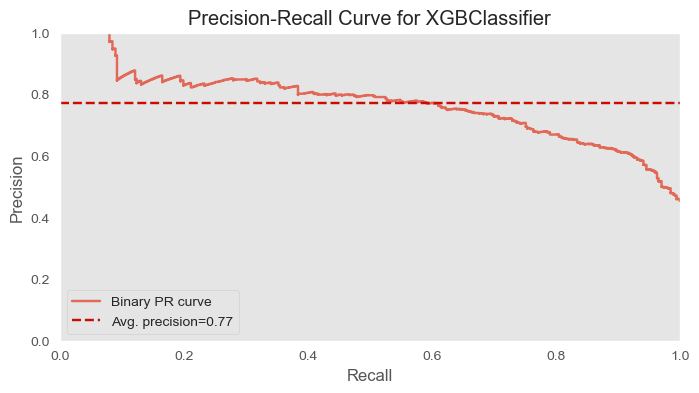

In [66]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.precision_recall_curve(
    xgb_def, X_train, y_train, X_test, y_test,
    micro=False, ax=ax, per_class=True
)
ax.set_ylim(0, 1.05)
plt.show()

# F1 Score

In [67]:
metrics.f1_score(y_test, xgb_def.predict(X_test))

0.7248803827751197

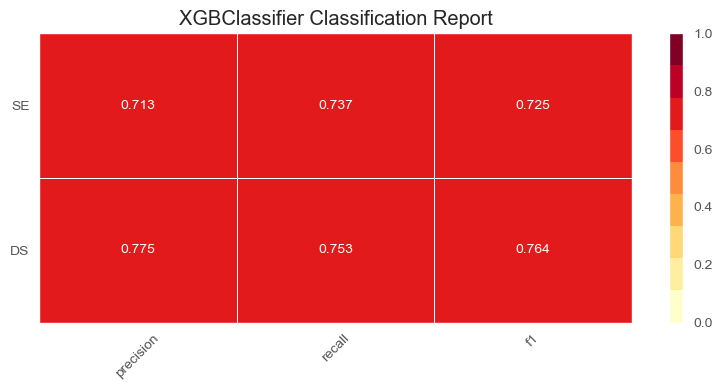

In [68]:
fig, ax = plt.subplots(figsize=(8, 4))
classifier.classification_report(xgb_def, X_train, y_train,
                                 X_test, y_test, classes=['DS', 'SE'],
                                 ax=ax, micro=False, macro=False)
plt.show()

# ROC Curve

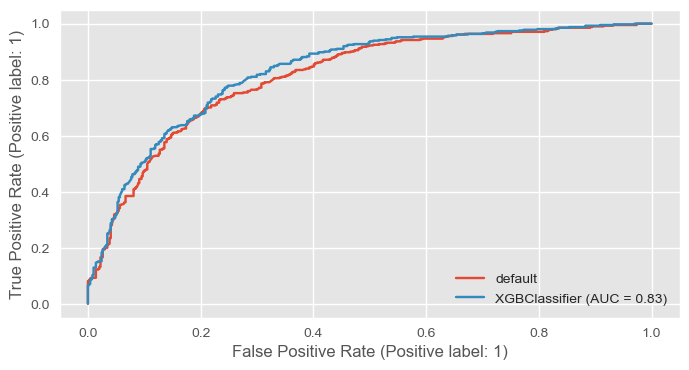

In [70]:
fig, ax = plt.subplots(figsize=(8, 4))
metrics.RocCurveDisplay.from_estimator(
    xgb_def, X_test, y_test, ax=ax, label='default'
)
metrics.RocCurveDisplay.from_estimator(
    xg_step, X_test, y_test, ax=ax
)
plt.show()

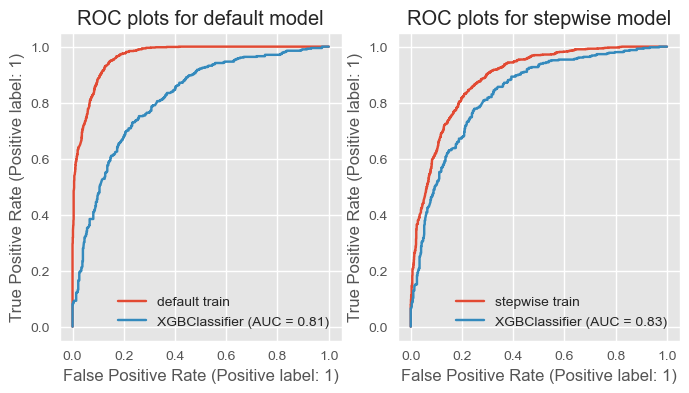

In [78]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
metrics.RocCurveDisplay.from_estimator(
    xgb_def, X_train, y_train, ax=axes[0], label='default train'
)
metrics.RocCurveDisplay.from_estimator(
    xgb_def, X_test, y_test, ax=axes[0]
)
ax=axes[0].set(title='ROC plots for default model')
metrics.RocCurveDisplay.from_estimator(
    xg_step, X_train, y_train, ax=axes[1], label='stepwise train'
)
metrics.RocCurveDisplay.from_estimator(
    xg_step, X_test, y_test, ax=axes[1]
)
axes[1].set(title='ROC plots for stepwise model')
plt.show()